# LLM Experience
Data : https://www.kaggle.com/datasets/wordsforthewise/lending-club?resource=download
Git : https://github.com/colfeng/CALM/tree/main

In [1]:
# pip install transformers datasets torch

In [4]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, GPT2Tokenizer, GPT2Model 

from tqdm import tqdm
import random
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.getcwd()
os.listdir()
os.listdir('Desktop')

[]

In [4]:
#####config
path = "~/Desktop/masterprojet/"
name = "accepted_2007_to_2018Q4.csv"
feature_size = 21 + 1  # Target_index = -1
train_size, dev_size, test_size = 0.7, 0.1, 0.2

if train_size + dev_size + test_size != 1:
    print("sample size wrong!!!")

mean_list = ['Installment', 'Loan Purpose', 'Loan Application Type', 'Interest Rate', 'Last Payment Amount',
             'Loan Amount', 'Revolving Balance',
             'Delinquency In 2 years', 'Inquiries In 6 Months', 'Mortgage Accounts', 'Grade', 'Open Accounts',
             'Revolving Utilization Rate', 'Total Accounts', 'Fico Range Low', 'Fico Range High',
             'Address State', 'Employment Length', 'Home Ownership', 'Verification Status', 'Annual Income',
             'Loan Status']


#####function
def process_table(data, mean_list):
    data_tmp = []
    prompt = 'Assess the client\'s loan status based on the following loan records from Lending Club. ' \
             'Respond with only \'good\' or \'bad\', and do not provide any additional information. For instance, ' \
             '\'The client has a stable income, no previous debts, and owns a property.\' ' \
             'should be classified as \'good\'. \nText: '

    for j in range(len(data)):
        text = 'The client has attributes as follows: '
        for i in range(len(data[0]) - 1):
            sp = '. ' if i != len(data[0]) - 2 else '.'
            if i == 3 or i == 12:
                text = text + f'The state of {mean_list[i]} is {str(data[j][i])}%' + sp
            else:
                text = text + f'The state of {mean_list[i]} is {str(data[j][i])}' + sp
        answer = 'good' if data[j][-1] == 'Fully Paid' else 'bad'
        gold = 0 if data[j][-1] == 'Fully Paid' else 1
        # 'Fully Paid' is good and 'Charged off' is bad
        data_tmp.append(
            {'id': j, "query": f"{prompt}'{text}'" + ' \nAnswer:', 'answer': answer, "choices": ["good", "bad"],
             "gold": gold, 'text': text})
    return data_tmp


def json_save(data, dataname, mean_list=mean_list, out_jsonl=False):
    
    if out_jsonl:
        with open('{}.jsonl'.format(dataname), 'w') as f:
            for i in data_tmp:
                json.dump(i, f)
                f.write('\n')
            print('-----------')
            print(f"{dataname}.jsonl write done")
        f.close()
    df = pd.DataFrame(data_tmp)
    # 保存为 Parquet 文件
    parquet_file_path = f'data/{dataname}.parquet'
    df.to_parquet(parquet_file_path, index=False)
    return data_tmp


def json_save_gpt4(data, dataname, mean_list=mean_list):
    data_tmp = process_table(data, mean_list)
    with open(f'gpt4-data/{dataname}.jsonl', 'w') as f:
        for i in data_tmp:
            json.dump(i, f)
            f.write('\n')
        print('-----------')
        print(f"{dataname}.jsonl write done")
    f.close()


def get_num(data):
    data_con = np.array(data)
    check = np.unique(data_con[:, -1])
    check1 = (data_con[:, -1] == check[0]).sum()
    check2 = (data_con[:, -1] == check[1]).sum()
    return check2, check1


def get_data(name):
    selected_feature = ['installment', 'purpose', 'application_type', 'int_rate', 'last_pymnt_amnt', 'loan_amnt',
                        'revol_bal', 'delinq_2yrs', 'inq_last_6mths', 'mort_acc', 'grade', 'open_acc', 'revol_util',
                        'total_acc', 'fico_range_low', 'fico_range_high', 'addr_state', 'emp_length', 'home_ownership',
                        'verification_status', 'annual_inc', 'loan_status']
    data = pd.read_csv(name, sep=',', header=0, low_memory=False, usecols=selected_feature).reindex(
        columns=selected_feature)
    # only reserve Fully Paid and Charged Off
    for loan_st in data['loan_status'].unique().tolist():
        if loan_st != 'Fully Paid' and loan_st != 'Charged Off':
            data = data.drop(data[data['loan_status'] == loan_st].index)
    data.dropna(subset=['loan_status'], inplace=True)
    save_data, drop_data = train_test_split(data, test_size=0.99, stratify=data['loan_status'], random_state=100)
    return save_data

#####process
data = get_data(name).values.tolist()
dev_prompt_data = process_table(data, mean_list)

In [5]:
df = pd.DataFrame(dev_prompt_data)
df = df.drop(['id', 'query','choices'], axis=1)
nb_unique_answer = df['answer'].value_counts()
nb_unique_gold = df['gold'].value_counts()
print("Lending_club_data_preprocess")
df,nb_unique_answer,nb_unique_gold

Lending_club_data_preprocess


(     answer  gold                                               text
 0      good     0  The client has attributes as follows: The stat...
 1      good     0  The client has attributes as follows: The stat...
 2      good     0  The client has attributes as follows: The stat...
 3       bad     1  The client has attributes as follows: The stat...
 4      good     0  The client has attributes as follows: The stat...
 ...     ...   ...                                                ...
 4862   good     0  The client has attributes as follows: The stat...
 4863   good     0  The client has attributes as follows: The stat...
 4864   good     0  The client has attributes as follows: The stat...
 4865   good     0  The client has attributes as follows: The stat...
 4866   good     0  The client has attributes as follows: The stat...
 
 [4867 rows x 3 columns],
 answer
 good    3848
 bad     1019
 Name: count, dtype: int64,
 gold
 0    3848
 1    1019
 Name: count, dtype: int64)

In [6]:
df["text"][0] #textbrut

'The client has attributes as follows: The state of Installment is 128.64. The state of Loan Purpose is other. The state of Loan Application Type is Individual. The state of Interest Rate is 19.19%. The state of Last Payment Amount is 1.45. The state of Loan Amount is 3500.0. The state of Revolving Balance is 3734.0. The state of Delinquency In 2 years is 0.0. The state of Inquiries In 6 Months is 2.0. The state of Mortgage Accounts is 5.0. The state of Grade is E. The state of Open Accounts is 8.0. The state of Revolving Utilization Rate is 43.4%. The state of Total Accounts is 13.0. The state of Fico Range Low is 695.0. The state of Fico Range High is 699.0. The state of Address State is PA. The state of Employment Length is 10+ years. The state of Home Ownership is MORTGAGE. The state of Verification Status is Source Verified. The state of Annual Income is 95000.0.'

In [7]:
# Charger le modèle GPT-2 et le tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2') #from hugging face
model = GPT2Model.from_pretrained('gpt2') #from hugging face

# Exemple de transformation de texte en embeddings
text = "Exemple de description de prêt"
inputs = tokenizer(text, return_tensors='pt')
outputs = model(**inputs)

# Utiliser les derniers hidden states comme représentation
embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
embeddings

array([[-1.60045754e-02, -5.22246301e-01,  1.58298180e-01,
        -1.02357760e-01,  2.36541033e-01,  5.96440621e-02,
         8.65453243e-01,  2.77336448e-01, -4.12510872e-01,
         1.94027349e-01,  1.38993695e-01, -2.43195161e-01,
         1.07838340e-01, -2.79341768e-02, -1.92481175e-01,
        -7.13974714e-01, -3.95880714e-02, -3.30543220e-01,
         3.99186552e-01,  2.45279849e-01,  1.75285116e-01,
        -1.63232535e-01, -1.04336880e-01,  2.77439982e-01,
         1.26096725e-01, -3.72457504e-02, -1.35774061e-01,
        -3.90360832e-01,  3.59126389e-01,  1.62359476e-01,
        -3.59259546e-01,  4.30876762e-02, -2.43196011e-01,
        -1.08340651e-01, -7.55208079e-03,  4.33813408e-02,
         5.68589935e+01, -2.67061502e-01, -1.64794162e-01,
         3.73267801e-03, -5.16224980e-01, -2.91938722e-01,
        -3.14786807e-02,  2.22103864e-01,  7.63526857e-02,
         2.05714822e-01, -3.39834988e-01,  8.45371783e-02,
        -4.68310237e-01, -1.78884659e-02,  2.37800941e-0

In [8]:
# Exemple de dataset
# data = {
#     'historique_paiement': [1, 0, 1, 1],
#     'solde_actuel': [5000, 3000, 7000, 2000],
#     'description_pret': ["Bon historique de crédit", "Risque élevé", "Paiements réguliers", "Prêt récent"]
# }

# df = pd.DataFrame(data)

# Transformer les descriptions de prêt en embeddings
embeddings_list = []
for desc in tqdm(df['text'],desc="text"):
    inputs = tokenizer(desc, return_tensors='pt')
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    embeddings_list.append(embeddings)

# Convertir en DataFrame et concaténer avec les autres features
embeddings_df = pd.DataFrame(np.vstack(embeddings_list))
df = pd.concat([df.drop('text', axis=1), embeddings_df], axis=1)

# Convertir tous les noms de colonnes en chaînes
df.columns = df.columns.astype(str)

text: 100%|██████████| 4867/4867 [46:51<00:00,  1.73it/s] 


In [9]:
df

,answer,gold,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,good,0,0.239115,0.122083,-0.313579,-0.163075,-0.115224,0.427207,10.847297,-0.053867,...,-0.443080,-0.368488,0.045452,0.083966,0.122820,0.035060,0.370073,0.051357,-0.017229,0.338153
1,good,0,0.253673,0.133437,-0.361379,-0.116997,-0.111633,0.361816,11.047422,-0.074484,...,-0.438518,-0.363894,0.056336,0.110346,0.172663,0.057134,0.407615,0.062597,-0.047034,0.348103
2,good,0,0.258780,0.085793,-0.396518,-0.122416,-0.095387,0.379011,11.620722,-0.081480,...,-0.457678,-0.348180,0.039276,0.117511,0.168116,0.066455,0.389476,0.064085,-0.052532,0.361715
3,bad,1,0.253309,0.116995,-0.404522,-0.127410,-0.118699,0.357831,11.125364,-0.067759,...,-0.456594,-0.383220,0.060741,0.088844,0.164534,0.051707,0.430426,0.052455,-0.060292,0.351433
4,good,0,0.269750,0.132233,-0.373239,-0.141112,-0.121650,0.465144,11.958580,-0.106886,...,-0.467134,-0.358194,0.043206,0.096611,0.205117,0.040410,0.425194,0.062635,-0.023654,0.327721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4862,good,0,0.270223,0.110518,-0.401057,-0.096840,-0.101770,0.374555,10.873922,-0.074936,...,-0.436476,-0.348072,0.071634,0.103065,0.139655,0.055859,0.399135,0.030732,-0.043642,0.363161
4863,good,0,0.259801,0.137108,-0.362538,-0.120950,-0.108019,0.381779,10.883654,-0.051336,...,-0.454291,-0.380805,0.060959,0.111399,0.128081,0.060788,0.401817,0.076383,-0.031286,0.340049
4864,good,0,0.273707,0.100863,-0.323505,-0.137183,-0.120061,0.419209,11.347270,-0.054111,...,-0.469286,-0.383608,0.091700,0.108606,0.154903,0.006380,0.394651,0.055800,-0.030282,0.347957
4865,good,0,0.259203,0.110678,-0.388868,-0.091496,-0.093029,0.361210,11.485964,-0.075834,...,-0.441068,-0.371305,0.048950,0.090420,0.200787,0.053295,0.422106,0.058091,-0.051436,0.344347


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Séparer les features et la cible
X = df.drop(['answer', 'gold'], axis=1) #input
y = df['answer'] #true

# Séparer en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner un modèle de Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8891170431211499


In [5]:
import pandas as pd

# Générer des données de clients IMAGINAIRE
data = {
    'client_id': range(1, 16),
    'gender': ['Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male'],
    'salary': [50000, 60000, 55000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000],
    'age': [25, 30, 28, 35, 40, 32, 45, 38, 50, 42, 55, 37, 60, 41, 65]
}

# Créer un DataFrame
df = pd.DataFrame(data)

# Afficher le DataFrame
print(df)



    client_id  gender  salary  age
0           1    Male   50000   25
1           2  Female   60000   30
2           3    Male   55000   28
3           4  Female   65000   35
4           5    Male   70000   40
5           6  Female   75000   32
6           7    Male   80000   45
7           8  Female   85000   38
8           9    Male   90000   50
9          10  Female   95000   42
10         11    Male  100000   55
11         12  Female  105000   37
12         13    Male  110000   60
13         14  Female  115000   41
14         15    Male  120000   65


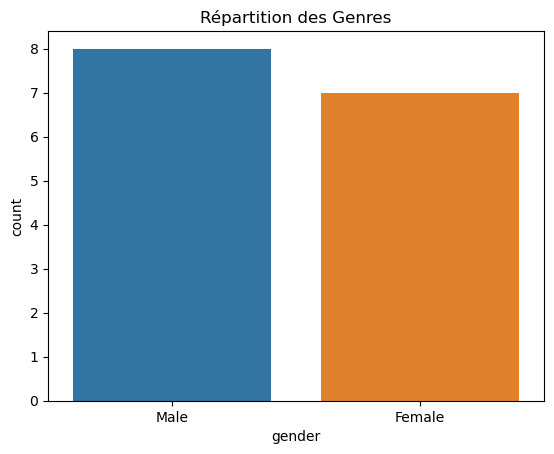

D:\codeprojects\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


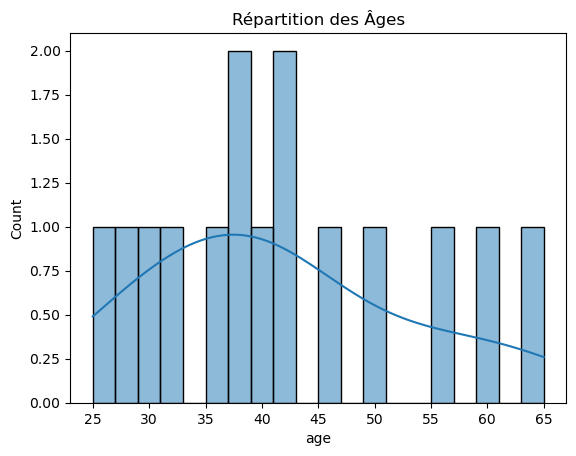

D:\codeprojects\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


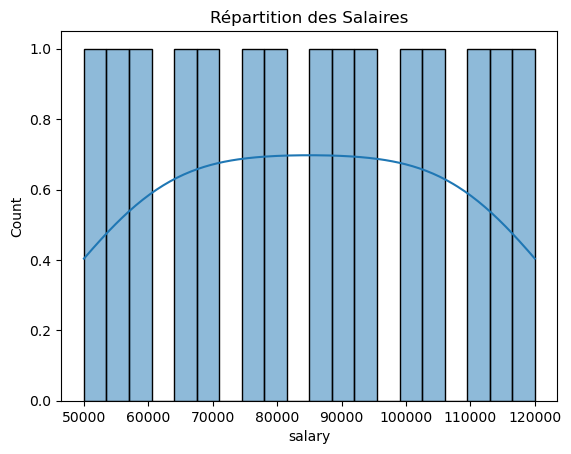

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogramme pour la répartition des genres IMAGINAIRE
sns.countplot(data=df, x='gender')
plt.title('Répartition des Genres')
plt.show()

# Histogramme pour la répartition des âges
sns.histplot(data=df, x='age', bins=20, kde=True)
plt.title('Répartition des Âges')
plt.show()

# Histogramme pour la répartition des salaires
sns.histplot(data=df, x='salary', bins=20, kde=True)
plt.title('Répartition des Salaires')
plt.show()

In [1]:
import pandas as pd
name = "accepted_2007_to_2018Q4.csv"

selected_feature = ['installment', 'purpose', 'application_type', 'int_rate', 'last_pymnt_amnt', 'loan_amnt',
                        'revol_bal', 'delinq_2yrs', 'inq_last_6mths', 'mort_acc', 'grade', 'open_acc', 'revol_util',
                        'total_acc', 'fico_range_low', 'fico_range_high', 'addr_state', 'emp_length', 'home_ownership',
                        'verification_status', 'annual_inc', 'loan_status']
data = pd.read_csv(name, sep=',', header=0).reindex(columns=selected_feature)

data

C:\Users\noemi\AppData\Local\Temp\ipykernel_11592\2320811502.py:8: DtypeWarning: Columns (0,19,59,118) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(name, sep=',', header=0).reindex(columns=selected_feature)


,installment,purpose,application_type,int_rate,last_pymnt_amnt,loan_amnt,revol_bal,delinq_2yrs,inq_last_6mths,mort_acc,...,revol_util,total_acc,fico_range_low,fico_range_high,addr_state,emp_length,home_ownership,verification_status,annual_inc,loan_status
0,123.03,debt_consolidation,Individual,13.99,122.67,3600.0,2765.0,0.0,1.0,1.0,...,29.7,13.0,675.0,679.0,PA,10+ years,MORTGAGE,Not Verified,55000.0,Fully Paid
1,820.28,small_business,Individual,11.99,926.35,24700.0,21470.0,1.0,4.0,4.0,...,19.2,38.0,715.0,719.0,SD,10+ years,MORTGAGE,Not Verified,65000.0,Fully Paid
2,432.66,home_improvement,Joint App,10.78,15813.30,20000.0,7869.0,0.0,0.0,5.0,...,56.2,18.0,695.0,699.0,IL,10+ years,MORTGAGE,Not Verified,63000.0,Fully Paid
3,829.90,debt_consolidation,Individual,14.85,829.90,35000.0,7802.0,0.0,0.0,1.0,...,11.6,17.0,785.0,789.0,NJ,10+ years,MORTGAGE,Source Verified,110000.0,Current
4,289.91,major_purchase,Individual,22.45,10128.96,10400.0,21929.0,1.0,3.0,6.0,...,64.5,35.0,695.0,699.0,PA,3 years,MORTGAGE,Source Verified,104433.0,Fully Paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722125,436.77,debt_consolidation,Individual,12.99,436.77,19200.0,5913.0,0.0,0.0,3.0,...,12.4,20.0,780.0,784.0,GA,10+ years,MORTGAGE,Not Verified,40000.0,Current
722126,648.38,credit_card,Individual,18.99,648.38,25000.0,16968.0,0.0,2.0,0.0,...,48.2,19.0,715.0,719.0,NM,10+ years,OWN,Not Verified,55000.0,Current
722127,374.97,debt_consolidation,Individual,17.27,374.97,15000.0,4213.0,0.0,0.0,0.0,...,37.0,11.0,695.0,699.0,VA,8 years,RENT,Not Verified,62544.0,Current
722128,272.98,debt_consolidation,Individual,12.99,10501.43,12000.0,10913.0,0.0,0.0,0.0,...,16.4,17.0,765.0,769.0,CT,5 years,RENT,Not Verified,51000.0,Fully Paid


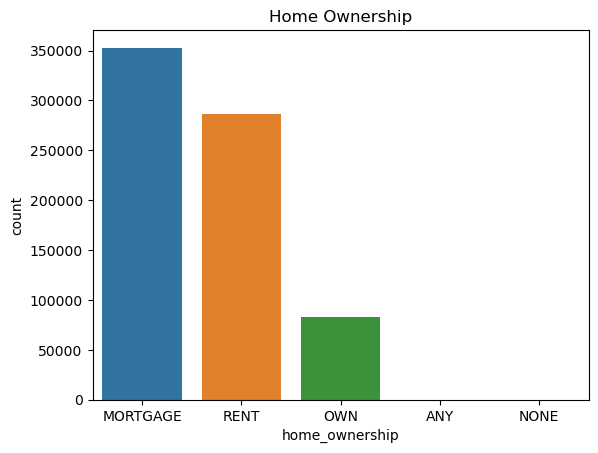

In [5]:
# Histogramme pour la répartition des genres IMAGINAIRE
sns.countplot(data=data, x='home_ownership')
plt.title('Home Ownership')
plt.show()


In [6]:
import pandas as pd
name = "accepted_2007_to_2018Q4.csv"

selected_feature = ['installment', 'purpose', 'application_type', 'int_rate', 'last_pymnt_amnt', 'loan_amnt',
                        'revol_bal', 'delinq_2yrs', 'inq_last_6mths', 'mort_acc', 'grade', 'open_acc', 'revol_util',
                        'total_acc', 'fico_range_low', 'fico_range_high', 'addr_state', 'emp_length', 'home_ownership',
                        'verification_status', 'annual_inc', 'loan_status']
data = pd.read_csv(name, sep=',', header=0, nrows=100)

data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
all_columns = data.columns.tolist()
print("All Columns: ", all_columns)

All Columns:  ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'ac

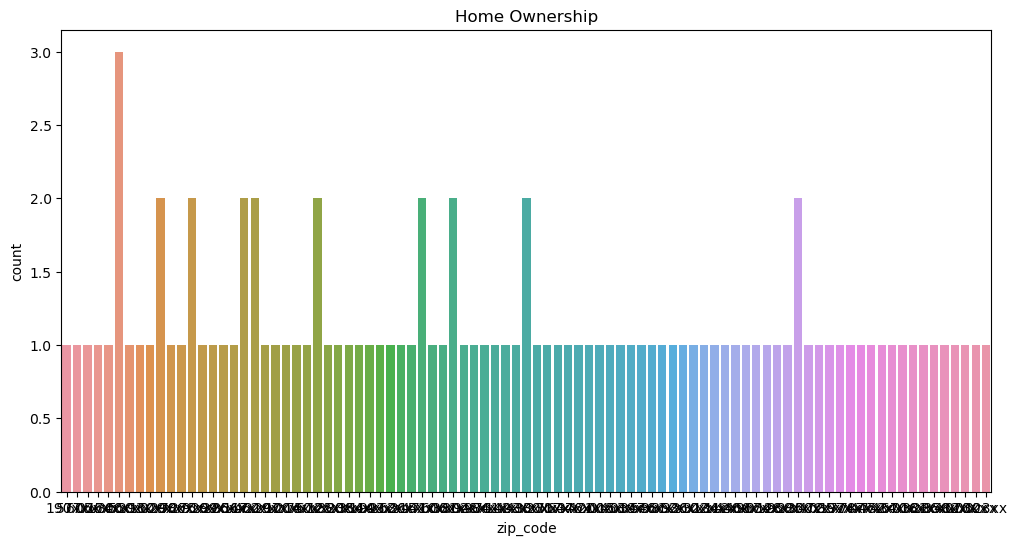

In [37]:
# Histogramme pour la répartition des genres IMAGINAIRE
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='zip_code')
plt.title('Home Ownership')
plt.show()

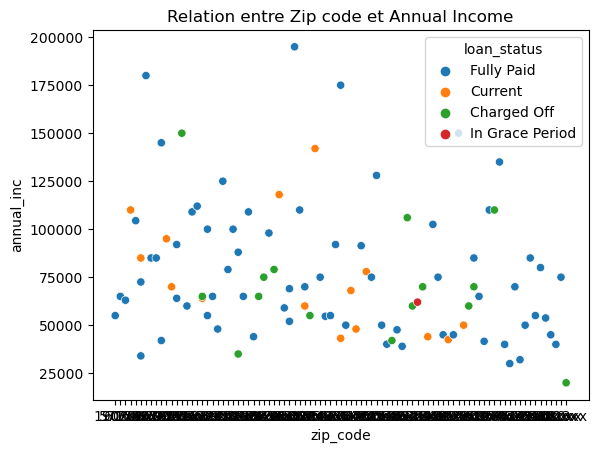

In [38]:
# Scatter plot pour la relation entre l'âge et le salaire
sns.scatterplot(data=data, x='zip_code', y='annual_inc', hue='loan_status')
plt.title('Relation entre Zip code et Annual Income')
plt.show()

#pas bcp de personne qui ont remboursé dans les gens qui sont en haut income

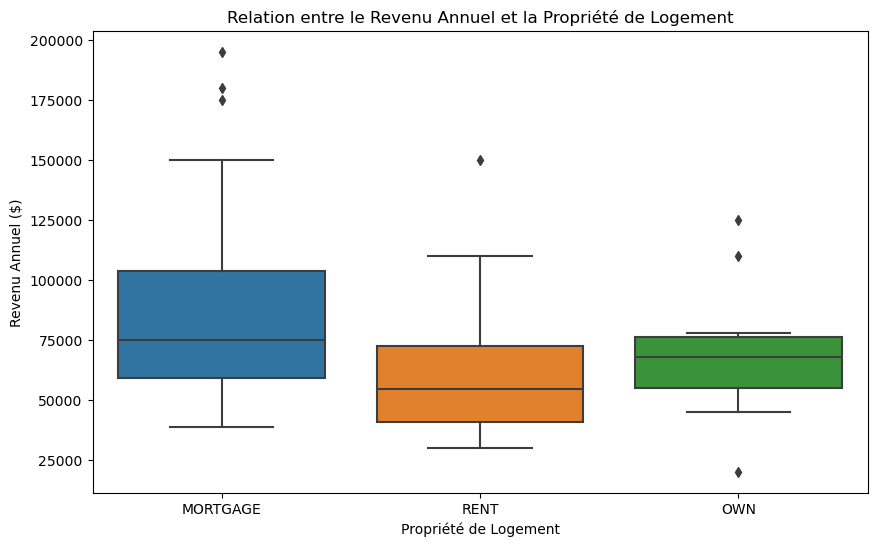

In [42]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='home_ownership', y='annual_inc', data=data)
plt.title('Relation entre le Revenu Annuel et la Propriété de Logement')
plt.xlabel('Propriété de Logement')
plt.ylabel('Revenu Annuel ($)')
plt.show()


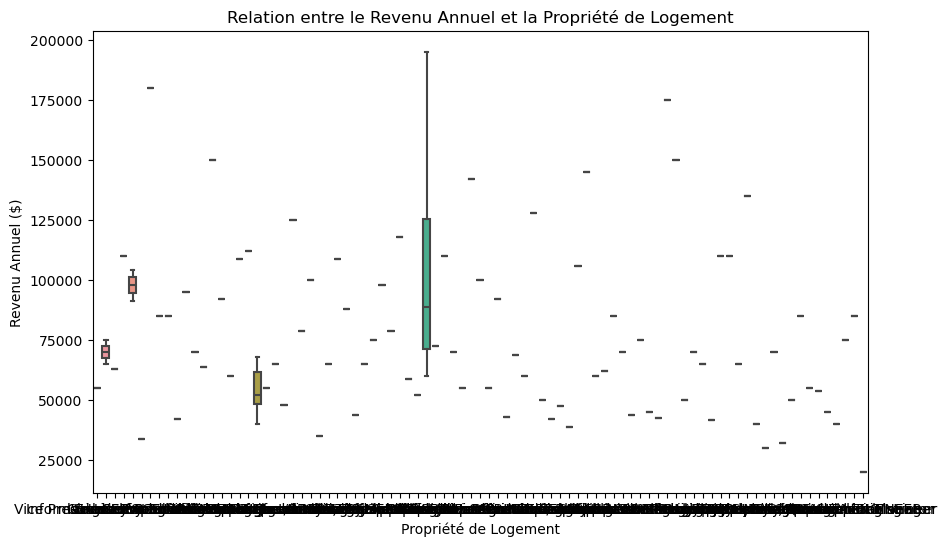

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='emp_title', y='annual_inc', data=data)
plt.title('Relation entre le Revenu Annuel et la Propriété de Logement')
plt.xlabel('Propriété de Logement')
plt.ylabel('Revenu Annuel ($)')
plt.show()

          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  int_rate  \
0   68407277        NaN     3600.0       3600.0           3600.0     13.99   
1   68355089        NaN    24700.0      24700.0          24700.0     11.99   
2   68341763        NaN    20000.0      20000.0          20000.0     10.78   
3   66310712        NaN    35000.0      35000.0          35000.0     14.85   
4   68476807        NaN    10400.0      10400.0          10400.0     22.45   
..       ...        ...        ...          ...              ...       ...   
95  68537564        NaN     8000.0       8000.0           8000.0     10.78   
96  68446784        NaN    12000.0      12000.0          12000.0     10.78   
97  68376533        NaN    18000.0      18000.0          18000.0      7.49   
98  68476714        NaN     3600.0       3600.0           3600.0     11.48   
99  66615254        NaN     7200.0       7200.0           7200.0     17.27   

    installment  annual_inc  desc    dti  ...  hardship_flag_N 

D:\codeprojects\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


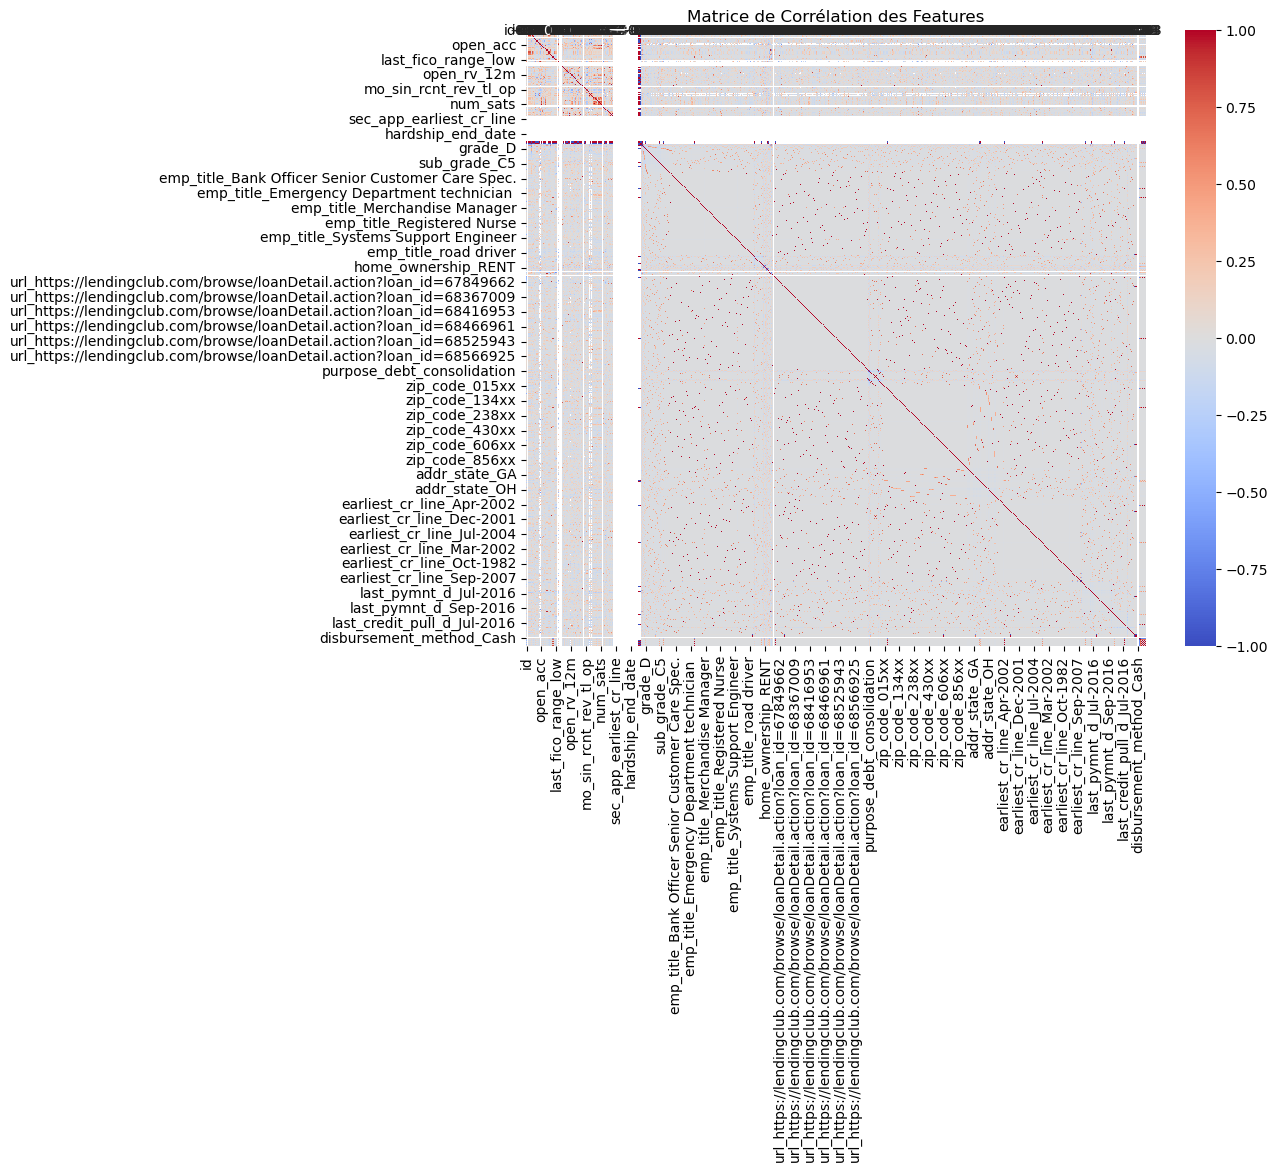

In [8]:
categorical_columns = data.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(data, columns=categorical_columns)
print(df_encoded)

corr_matrix = df_encoded.corr()

# Afficher la matrice de corrélation avec Seaborn
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de Corrélation des Features')
plt.show()

In [ ]:
#create subfeatures that are most relevant